<a href="https://colab.research.google.com/github/MorganaMacedo/ArvoreRubroNegra/blob/master/TrabalhoFinal_AM_CNN_SemWavelet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Banco de dados Respiratory sound, disponível para download no site:
---
https://bhichallenge.med.auth.gr/ICBHI_2017_Challenge

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
!pip install wavio

In [11]:
!pip install keras

In [12]:
!pip install pydub

In [13]:
!pip install -U tensorflow-addons
!pip install -q "tqdm>=4.36.1"

     |████████████████████████████████| 1.1 MB 5.9 MB/s 


In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import librosa
import librosa.display
from datetime import datetime
from os import listdir
from os.path import isfile, join
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint 
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

In [15]:
audio_bd = '/content/drive/MyDrive/Trabalho_AM_DMA/events/'
audio_wav = [i for i in listdir(audio_bd) if (isfile(join(audio_bd, i)) and i.endswith('.wav'))] 

In [16]:
id = [] 
for audio_nome in audio_wav:
    id.append(int(audio_nome[:3]))

id = np.array(id) 

In [17]:
max_pad_len = 862 # to make the length of all MFCC equal

def extract_features(file_name):
    """
    This function takes in the path for an audio file as a string, loads it, and returns the MFCC
    of the audio"""
   
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=20) 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
     
    return mfccs

In [18]:
todos_audio = [join(audio_bd, i) for i in audio_wav]

In [19]:
doenca = pd.read_csv('/content/drive/MyDrive/Trabalho_AM_DMA/patient_diagnosis.csv',header=None) # patient diagnosis file

In [20]:
labels = np.array([doenca[doenca[0] == x][1].values[0] for x in id])

In [21]:
audios = [] 

for file_name in todos_audio:
    dado = extract_features(file_name)
    audios.append(dado)

print('Número de amostras', len(audios), ' de áudio')
audios = np.array(audios)

Número de amostras 920  de áudio


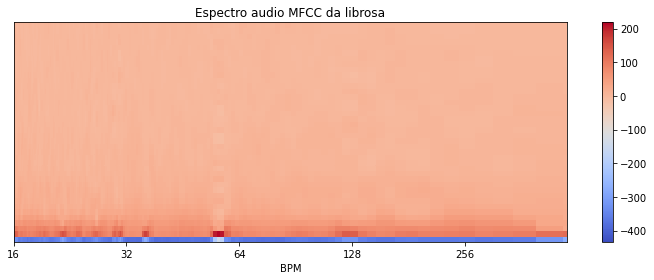

In [22]:
plt.figure(figsize=(10, 4))
librosa.display.specshow(audios[7], x_axis='tempo')
plt.colorbar()
plt.title('Espectro audio MFCC da librosa')
plt.tight_layout()
plt.show()

In [23]:
audios = np.array(audios) 

In [24]:
audios1 = np.delete(audios, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0) 
labels1 = np.delete(labels, np.where((labels == 'Asthma') | (labels == 'LRTI'))[0], axis=0)

In [25]:
unicos, count = np.unique(labels1, return_counts=True)
print(np.asarray((unicos, count)))

[['Bronchiectasis' 'Bronchiolitis' 'COPD' 'Healthy' 'Pneumonia' 'URTI']
 ['16' '13' '793' '35' '37' '23']]


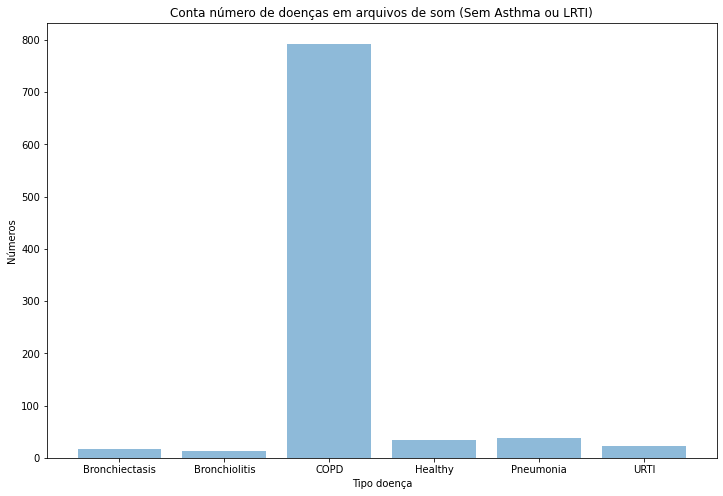

In [26]:
y_pos = np.arange(len(unicos))
plt.figure(figsize=(12,8))
plt.bar(unicos, count, align='center', alpha=0.5)
plt.xticks(y_pos, unicos)
plt.ylabel('Números')
plt.xlabel('Tipo doença')
plt.title('Conta número de doenças em arquivos de som (Sem Asthma ou LRTI)')
plt.show()

In [27]:
le = LabelEncoder()
transf = le.fit_transform(labels1)
categorico = to_categorical(transf) 

In [28]:
audios1 = np.reshape(audios1, (*audios1.shape,1)) 

In [29]:
X_treino, X_teste, Y_treino, Y_teste = train_test_split(audios1, categorico, stratify=categorico, test_size=0.2, random_state = 42)

In [30]:
linhas = 40
colunas = 862
canal = 1

num_labels = categorico.shape[1]
tam_filtro = 2
###############################################################################################################################
modelo = Sequential()
modelo.add(Conv2D(filters=16, kernel_size=tam_filtro, input_shape=(linhas, colunas, canal), activation='relu'))
modelo.add(MaxPooling2D(pool_size=2))
modelo.add(Dropout(0.2))
###############################################################################################################################
modelo.add(Conv2D(filters=32, kernel_size=tam_filtro, activation='relu'))
modelo.add(MaxPooling2D(pool_size=2))
modelo.add(Dropout(0.2))
###############################################################################################################################
modelo.add(Conv2D(filters=64, kernel_size=tam_filtro, activation='relu'))
modelo.add(MaxPooling2D(pool_size=2))
modelo.add(Dropout(0.2))
###############################################################################################################################
modelo.add(Conv2D(filters=128, kernel_size=tam_filtro, activation='relu'))
modelo.add(MaxPooling2D(pool_size=2))
modelo.add(Dropout(0.2))
###############################################################################################################################
modelo.add(GlobalAveragePooling2D())
modelo.add(Dense(num_labels, activation='softmax')) 

In [31]:
modelo.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

In [32]:
modelo.summary()
score = modelo.evaluate(X_teste, Y_teste, verbose=1)
acuracia = 100*score[1]
print("Acurácia pré treinamento: %.4f%%" % acuracia)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 39, 861, 16)       80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 430, 16)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 19, 430, 16)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 18, 429, 32)       2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 9, 214, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 9, 214, 32)        0

#Treinamento#

In [34]:
import os
os.makedirs('/content/drive/MyDrive/Trabalho_AM_DMA/salvaModelo1/')

In [35]:
epocas = 250
batch = 128

callbacks = [
    ModelCheckpoint(filepath='/content/drive/MyDrive/Trabalho_AM_DMA/salvaModelo1/modelo2_{epoch:02d}.h5',save_best_only=True,monitor='val_accuracy', verbose=1)
]
comeco = datetime.now()
modelo.fit(X_treino, Y_treino, batch_size=batch, epochs=epocas,validation_data=(X_teste, Y_teste), callbacks=callbacks, verbose=1)

duracao = datetime.now() - comeco
print("Tempo de treinamento: ", duracao)

Epoch 1/250
6/6 [==============================] - ETA: 0s - loss: 5.8259 - accuracy: 0.6289
Epoch 00001: val_accuracy improved from -inf to 0.85870, saving model to /content/drive/MyDrive/Trabalho_AM_DMA/salvaModelo1/modelo2_01.h5
6/6 [==============================] - 19s 3s/step - loss: 5.8259 - accuracy: 0.6289 - val_loss: 1.8956 - val_accuracy: 0.8587
Epoch 2/250
6/6 [==============================] - ETA: 0s - loss: 3.1673 - accuracy: 0.8363
Epoch 00002: val_accuracy did not improve from 0.85870
6/6 [==============================] - 18s 3s/step - loss: 3.1673 - accuracy: 0.8363 - val_loss: 1.3974 - val_accuracy: 0.8533
Epoch 3/250
6/6 [==============================] - ETA: 0s - loss: 2.1275 - accuracy: 0.7995
Epoch 00003: val_accuracy did not improve from 0.85870
6/6 [==============================] - 17s 3s/step - loss: 2.1275 - accuracy: 0.7995 - val_loss: 1.5551 - val_accuracy: 0.6685
Epoch 4/250
6/6 [==============================] - ETA: 0s - loss: 1.5848 - accuracy: 0.837

#Teste#


In [36]:
score = modelo.evaluate(X_treino, Y_treino, verbose=0)
print("Acurácia Treino: ", score[1])

score = modelo.evaluate(X_teste, Y_teste, verbose=0)
print("Acurácia Teste: ", score[1])

Acurácia Treino:  0.9508867859840393
Acurácia Teste:  0.8913043737411499


In [37]:
pred = modelo.predict(X_teste) 
classpred = np.argmax(pred, axis=1) 
Y_teste_classe = np.argmax(Y_teste, axis=1) 
n_classes=6 

In [38]:
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_teste[:, i], pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [39]:
nome_doenca = ['Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'Pneumonia', 'URTI']

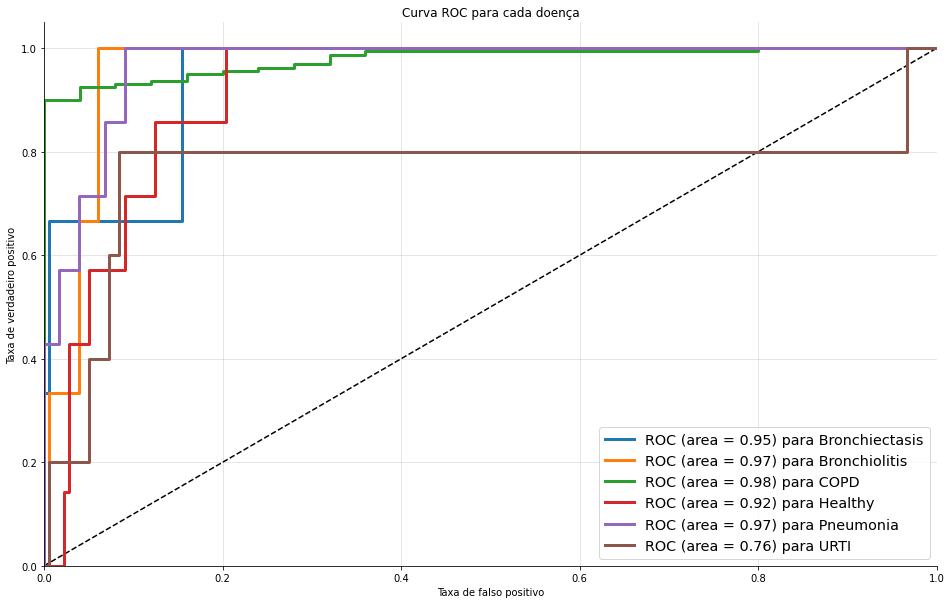

In [40]:
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('Taxa de falso positivo')
ax.set_ylabel('Taxa de verdadeiro positivo')
ax.set_title('Curva ROC para cada doença')
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], linewidth=3, label='ROC (area = %0.2f) para %s' % (roc_auc[i], nome_doenca[i]))
ax.legend(loc="best", fontsize='x-large')
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [41]:
matrix_index = ["Bronchiectasis", "Bronchiolitis","COPD",  "Pneumoina" ,"Healthy", "URTI"]

pred = modelo.predict(X_teste)
classpred = np.argmax(pred, axis=1) 
Y_teste_classe = np.argmax(Y_teste, axis=1)

cm = confusion_matrix(Y_teste_classe, classpred)
print(classification_report(Y_teste_classe, classpred, target_names=matrix_index))


                precision    recall  f1-score   support

Bronchiectasis       1.00      0.33      0.50         3
 Bronchiolitis       0.33      0.33      0.33         3
          COPD       0.93      0.99      0.96       159
     Pneumoina       0.00      0.00      0.00         7
       Healthy       0.75      0.43      0.55         7
          URTI       0.17      0.20      0.18         5

      accuracy                           0.89       184
     macro avg       0.53      0.38      0.42       184
  weighted avg       0.86      0.89      0.87       184



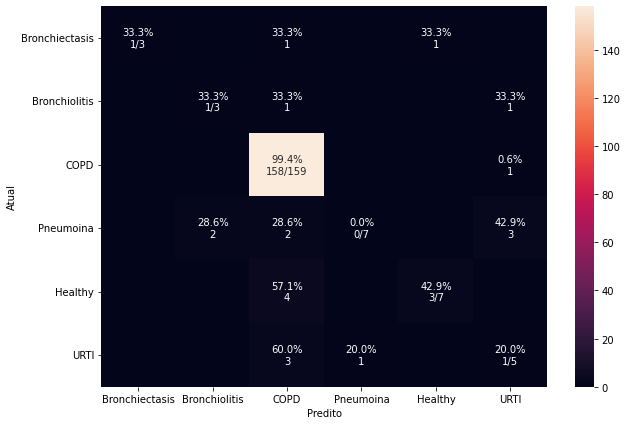

In [42]:
cm_sum = np.sum(cm, axis=1, keepdims=True)
cm_perc = cm / cm_sum.astype(float) * 100
annot = np.empty_like(cm).astype(str)
nrows, ncols = cm.shape
for i in range(nrows):
    for j in range(ncols):
        c = cm[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)


df_cm = pd.DataFrame(cm, index = matrix_index, columns = matrix_index)
df_cm.index.name = 'Atual'
df_cm.columns.name = 'Predito'
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(df_cm, annot=annot, fmt='')